In [18]:
from IPython.display import HTML

url = "https://cifar-10-cnn-byluvgoel.netlify.app/"

HTML(f"""
<style>@keyframes g{{0%,100%{{background-position:0 50%}}50%{{background-position:100% 50%}}}}</style>
<div style="text-align:center;padding:20px;background:linear-gradient(135deg,#667eea,#764ba2,#667eea);background-size:200%;animation:g 4s ease infinite;border-radius:10px">
<h2 style="color:#fff;margin:0 0 5px">CIFAR-10 CNN Classifier Demo by Luv Goel</h2><br>
<a href="{url}" target="_blank" style="display:inline-block;padding:15px 40px;background:#fff;color:#667eea;font-weight:bold;font-size:16px;border-radius:10px;box-shadow:0 5px 15px rgba(0,0,0,.3);text-decoration:none;transition:transform .3s" onmouseover="this.style.transform='scale(1.05)'" onmouseout="this.style.transform='scale(1)'">Click Here to Open Website</a>
</div>
""")

In [4]:
"""
CIFAR-10 CNN Classifier - Built from Scratch
A deep CNN with batch normalization, dropout, and max pooling
This implementation uses PyTorch to build an effective CNN architecture for image classification on the CIFAR-10 dataset.
"""

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [5]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [6]:
# 1. DATA LOADING AND PREPROCESSING

# Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomCrop(32, padding=4),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Only normalization for testing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load CIFAR-10 dataset
print("Downloading CIFAR-10 dataset...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

# CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Training samples: {len(trainset)}")
print(f"Test samples: {len(testset)}")

100%|██████████| 170M/170M [00:02<00:00, 79.6MB/s]


Training samples: 50000
Test samples: 10000


In [7]:
# 2. CNN ARCHITECTURE DEFINITION

class CIFAR10_CNN(nn.Module):
    """
    Deep CNN with 6 convolutional layers, batch normalization,
    dropout, and max pooling.

    Architecture:
    - Block 1: Conv(3→32) → BN → ReLU → Conv(32→32) → BN → ReLU → MaxPool → Dropout(0.2)
    - Block 2: Conv(32→64) → BN → ReLU → Conv(64→64) → BN → ReLU → MaxPool → Dropout(0.3)
    - Block 3: Conv(64→128) → BN → ReLU → Conv(128→128) → BN → ReLU → MaxPool → Dropout(0.4)
    - Classifier: Flatten → FC(2048→512) → ReLU → Dropout(0.5) → FC(512→10)
    """

    def __init__(self):
        super(CIFAR10_CNN, self).__init__()

        # Block 1: Edge Detection (32x32 -> 16x16)
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 3 input channels (RGB)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32x32 -> 16x16
            nn.Dropout(0.2)
        )

        # Block 2: Texture Detection (16x16 -> 8x8)
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16x16 -> 8x8
            nn.Dropout(0.3)
        )

        # Block 3: Object Parts (8x8 -> 4x4)
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 8x8 -> 4x4
            nn.Dropout(0.4)
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 512),  # 128 channels * 4x4 spatial = 2048
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 10)  # 10 classes
        )

    def forward(self, x):
        """Forward pass through the network"""
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.classifier(x)
        return x

# Create model instance
model = CIFAR10_CNN().to(device)

# Print model architecture
print("\n" + "="*70)
print("CNN ARCHITECTURE")
print("="*70)
print(model)
print("="*70)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


CNN ARCHITECTURE
CIFAR10_CNN(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_s

In [9]:
# 3. TRAINING SETUP

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer with weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler - reduce LR when plateauing
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                   factor=0.5, patience=3)

In [10]:
# 4. TRAINING AND VALIDATION FUNCTIONS

def train_epoch(model, trainloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(trainloader, desc='Training')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update progress bar
        pbar.set_postfix({
            'loss': f'{running_loss/len(pbar):.3f}',
            'acc': f'{100.*correct/total:.2f}%'
        })

    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, testloader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(testloader, desc='Validation')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Update progress bar
            pbar.set_postfix({
                'loss': f'{running_loss/len(pbar):.3f}',
                'acc': f'{100.*correct/total:.2f}%'
            })

    epoch_loss = running_loss / len(testloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

In [11]:
# 5. TRAINING LOOP

num_epochs = 20
best_acc = 0.0

# Lists to store metrics
train_losses = []
train_accs = []
val_losses = []
val_accs = []

print("\n" + "="*70)
print("STARTING TRAINING")
print("="*70 + "\n")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 50)

    # Train
    train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc = validate(model, testloader, criterion, device)

    # Update learning rate
    scheduler.step(val_loss)

    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_cifar10_cnn.pth')
        print(f"  ✓ New best model saved! (Acc: {best_acc:.2f}%)")

print("\n" + "="*70)
print("TRAINING COMPLETED")
print("="*70)
print(f"Best Validation Accuracy: {best_acc:.2f}%")


STARTING TRAINING


Epoch 1/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:25<00:00,  3.12it/s, loss=1.242, acc=54.95%]



Epoch 1 Summary:
  Train Loss: 1.5936 | Train Acc: 41.08%
  Val Loss:   1.2418 | Val Acc:   54.95%
  ✓ New best model saved! (Acc: 54.95%)

Epoch 2/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:30<00:00,  2.62it/s, loss=1.058, acc=62.16%]



Epoch 2 Summary:
  Train Loss: 1.2135 | Train Acc: 56.55%
  Val Loss:   1.0584 | Val Acc:   62.16%
  ✓ New best model saved! (Acc: 62.16%)

Epoch 3/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:25<00:00,  3.09it/s, loss=0.922, acc=67.30%]



Epoch 3 Summary:
  Train Loss: 1.0622 | Train Acc: 62.33%
  Val Loss:   0.9222 | Val Acc:   67.30%
  ✓ New best model saved! (Acc: 67.30%)

Epoch 4/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:25<00:00,  3.05it/s, loss=0.801, acc=71.46%]



Epoch 4 Summary:
  Train Loss: 0.9573 | Train Acc: 66.30%
  Val Loss:   0.8014 | Val Acc:   71.46%
  ✓ New best model saved! (Acc: 71.46%)

Epoch 5/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:27<00:00,  2.87it/s, loss=0.797, acc=71.95%]



Epoch 5 Summary:
  Train Loss: 0.8877 | Train Acc: 68.94%
  Val Loss:   0.7966 | Val Acc:   71.95%
  ✓ New best model saved! (Acc: 71.95%)

Epoch 6/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:27<00:00,  2.91it/s, loss=0.708, acc=75.01%]



Epoch 6 Summary:
  Train Loss: 0.8259 | Train Acc: 71.09%
  Val Loss:   0.7080 | Val Acc:   75.01%
  ✓ New best model saved! (Acc: 75.01%)

Epoch 7/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:27<00:00,  2.92it/s, loss=0.625, acc=78.23%]



Epoch 7 Summary:
  Train Loss: 0.7906 | Train Acc: 72.61%
  Val Loss:   0.6254 | Val Acc:   78.23%
  ✓ New best model saved! (Acc: 78.23%)

Epoch 8/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:26<00:00,  2.96it/s, loss=0.666, acc=76.87%]



Epoch 8 Summary:
  Train Loss: 0.7530 | Train Acc: 74.04%
  Val Loss:   0.6663 | Val Acc:   76.87%

Epoch 9/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:27<00:00,  2.90it/s, loss=0.571, acc=80.19%]



Epoch 9 Summary:
  Train Loss: 0.7197 | Train Acc: 75.38%
  Val Loss:   0.5715 | Val Acc:   80.19%
  ✓ New best model saved! (Acc: 80.19%)

Epoch 10/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:27<00:00,  2.88it/s, loss=0.564, acc=80.45%]



Epoch 10 Summary:
  Train Loss: 0.6918 | Train Acc: 76.40%
  Val Loss:   0.5639 | Val Acc:   80.45%
  ✓ New best model saved! (Acc: 80.45%)

Epoch 11/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:27<00:00,  2.88it/s, loss=0.583, acc=80.13%]



Epoch 11 Summary:
  Train Loss: 0.6672 | Train Acc: 77.21%
  Val Loss:   0.5825 | Val Acc:   80.13%

Epoch 12/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:28<00:00,  2.74it/s, loss=0.554, acc=81.12%]



Epoch 12 Summary:
  Train Loss: 0.6496 | Train Acc: 78.04%
  Val Loss:   0.5535 | Val Acc:   81.12%
  ✓ New best model saved! (Acc: 81.12%)

Epoch 13/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:28<00:00,  2.77it/s, loss=0.610, acc=79.45%]



Epoch 13 Summary:
  Train Loss: 0.6277 | Train Acc: 78.83%
  Val Loss:   0.6103 | Val Acc:   79.45%

Epoch 14/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:29<00:00,  2.71it/s, loss=0.497, acc=83.15%]



Epoch 14 Summary:
  Train Loss: 0.6138 | Train Acc: 79.19%
  Val Loss:   0.4969 | Val Acc:   83.15%
  ✓ New best model saved! (Acc: 83.15%)

Epoch 15/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:29<00:00,  2.68it/s, loss=0.499, acc=82.74%]



Epoch 15 Summary:
  Train Loss: 0.5929 | Train Acc: 79.85%
  Val Loss:   0.4993 | Val Acc:   82.74%

Epoch 16/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:31<00:00,  2.52it/s, loss=0.466, acc=84.01%]



Epoch 16 Summary:
  Train Loss: 0.5804 | Train Acc: 80.63%
  Val Loss:   0.4661 | Val Acc:   84.01%
  ✓ New best model saved! (Acc: 84.01%)

Epoch 17/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:31<00:00,  2.52it/s, loss=0.499, acc=83.08%]



Epoch 17 Summary:
  Train Loss: 0.5692 | Train Acc: 80.69%
  Val Loss:   0.4993 | Val Acc:   83.08%

Epoch 18/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:31<00:00,  2.49it/s, loss=0.516, acc=82.61%]



Epoch 18 Summary:
  Train Loss: 0.5567 | Train Acc: 81.34%
  Val Loss:   0.5158 | Val Acc:   82.61%

Epoch 19/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:31<00:00,  2.48it/s, loss=0.457, acc=84.83%]



Epoch 19 Summary:
  Train Loss: 0.5374 | Train Acc: 81.73%
  Val Loss:   0.4570 | Val Acc:   84.83%
  ✓ New best model saved! (Acc: 84.83%)

Epoch 20/20
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:32<00:00,  2.40it/s, loss=0.463, acc=84.66%]


Epoch 20 Summary:
  Train Loss: 0.5305 | Train Acc: 82.03%
  Val Loss:   0.4631 | Val Acc:   84.66%

TRAINING COMPLETED
Best Validation Accuracy: 84.83%


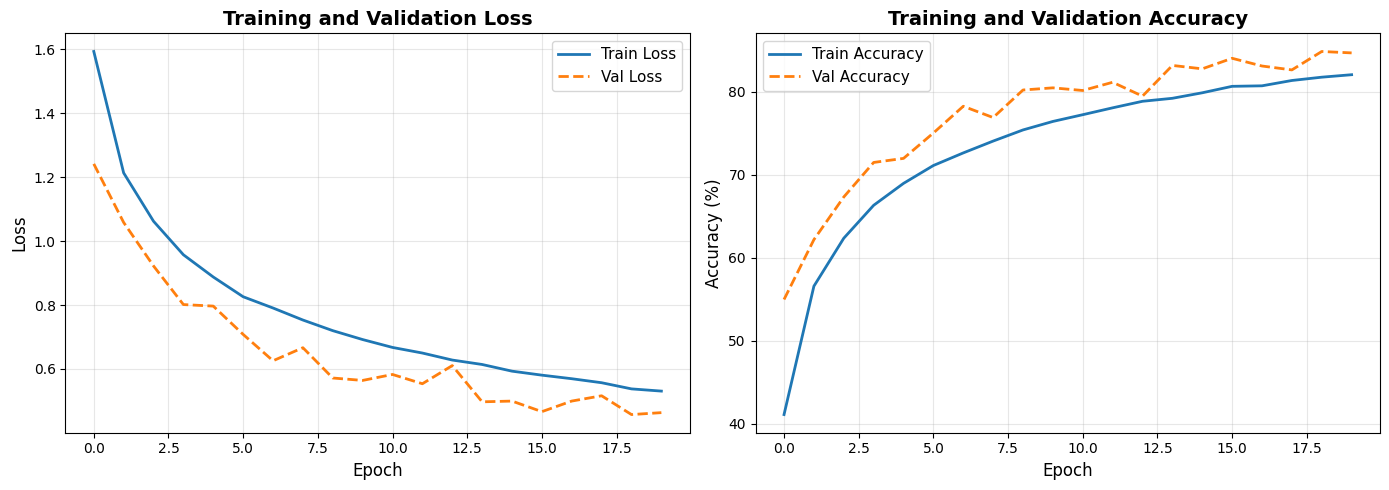

In [12]:
# 6. VISUALIZATION

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(train_losses, label='Train Loss', linewidth=2)
ax1.plot(val_losses, label='Val Loss', linewidth=2, linestyle='--')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(train_accs, label='Train Accuracy', linewidth=2)
ax2.plot(val_accs, label='Val Accuracy', linewidth=2, linestyle='--')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# 7. TEST FINAL MODEL

# Load best model
model.load_state_dict(torch.load('best_cifar10_cnn.pth'))
model.eval()

# Test on entire test set
print("FINAL EVALUATION ON TEST SET")

correct = 0
total = 0
class_correct = [0] * 10
class_total = [0] * 10

with torch.no_grad():
    for inputs, labels in tqdm(testloader, desc='Testing'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Per-class accuracy
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1

# Overall accuracy
print(f"\nOverall Test Accuracy: {100 * correct / total:.2f}%")

# Per-class accuracy
print("\nPer-Class Accuracy:")
print("-" * 40)
for i in range(10):
    acc = 100 * class_correct[i] / class_total[i]
    print(f"{classes[i]:>10s}: {acc:>6.2f}%")

FINAL EVALUATION ON TEST SET


Testing: 100%|██████████| 79/79 [00:33<00:00,  2.35it/s]


Overall Test Accuracy: 84.83%

Per-Class Accuracy:
----------------------------------------
     plane:  86.40%
       car:  92.70%
      bird:  70.00%
       cat:  67.80%
      deer:  86.60%
       dog:  77.40%
      frog:  93.20%
     horse:  90.30%
      ship:  90.90%
     truck:  93.00%


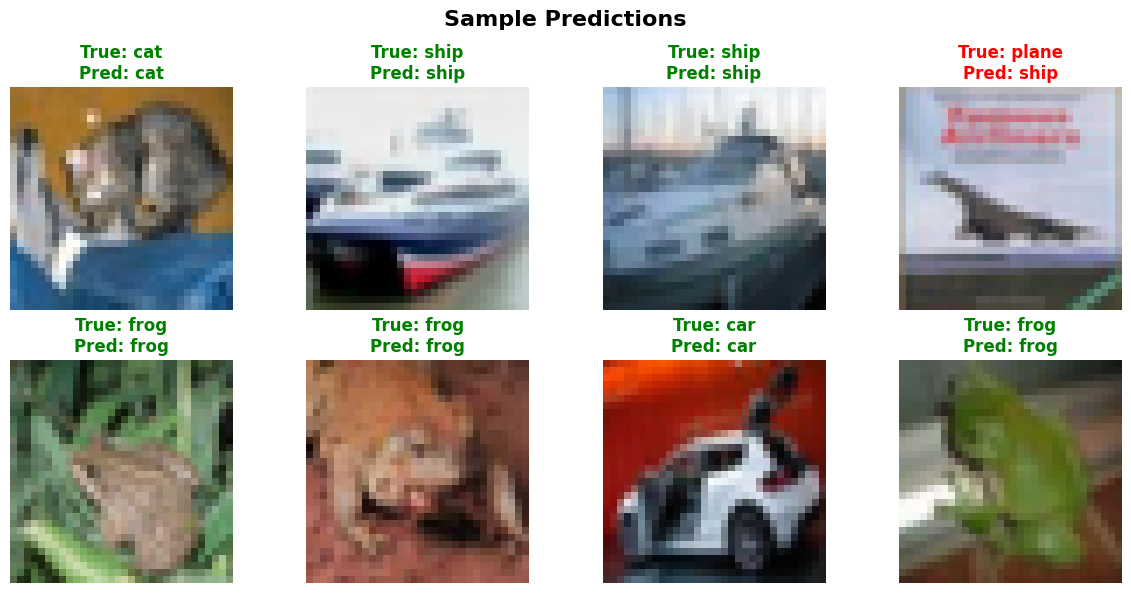

ALL DONE!
Files saved:
  - best_cifar10_cnn.pth (model weights)
  - training_history.png (loss & accuracy curves)
  - sample_predictions.png (visual results)


In [17]:
# 8. VISUALIZE PREDICTIONS

def imshow(img, title=None):
    """Display image"""
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')

# Get some random test images
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Get predictions
with torch.no_grad():
    outputs = model(images)
    _, predicted = outputs.max(1)

# Show 8 sample predictions
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle('Sample Predictions', fontsize=16, fontweight='bold')

for idx, ax in enumerate(axes.flat):
    img = images[idx].cpu()
    true_label = classes[labels[idx]]
    pred_label = classes[predicted[idx]]

    imshow(img, title=f'True: {true_label}\nPred: {pred_label}')
    ax.imshow(np.transpose((img / 2 + 0.5).numpy(), (1, 2, 0)))

    # Color code: green if correct, red if wrong
    color = 'green' if labels[idx] == predicted[idx] else 'red'
    ax.set_title(f'True: {true_label}\nPred: {pred_label}',
                 color=color, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("ALL DONE!")
print("Files saved:")
print("  - best_cifar10_cnn.pth (model weights)")
print("  - training_history.png (loss & accuracy curves)")
print("  - sample_predictions.png (visual results)")